In [1]:
import numpy as np 
%matplotlib ipympl 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_interactions import image_segmenter
import ipywidgets as widgets
from ipyfilechooser import FileChooser
import pandas as pd
import os
import warnings
from itertools import zip_longest
warnings.filterwarnings('ignore')

## Preamble: Useful functions (to run)

In [2]:
def clean_df(df): 
    """Makes sure that df elements are floats and replaces
    inf with nan for easier data manipulation."""
    a = df.astype(float).replace([-np.inf,+np.inf],np.nan)
    return a

# Introduction
This notebook allows to visualise and manipulate Brillouin Spectroscopy maps (in terms of frequency shift, $\nu_B$) acquired and processed using the light machinery set-up (https://lightmachinery.com/). In brief, the "Scan_Parameters_and_Analysis.csv" file is first imported and manipulated so that the Brillouin map ($\nu_B$) can be shown as a color map with appropriate $x$ and $y$ coordinates. Then, $\nu_B$ profiles are shown along both $x$ and $y$ as line plots. Finally, the possibility to isolate the background from the objects of interest (e.g., cells, spheroids etc) is given using a simple threshold; and the average of both background and object can be computed and saved. <br> 
The notebook has been made interactive via widgets to be more user friendly. A step by step workflow is summarised below: 

### 1) Run cell below to upload the  "Scan_Parameters_and_Analysis.csv" file 

In [3]:
fc = FileChooser()
display(fc)

FileChooser(path='/Users/giuseppeciccone/Library/CloudStorage/OneDrive-UniversityofGlasgow/PhD/PyModules/brill…

### 2) Run cells below to clean data
Because the "Scan_parameters_and_Analysis.csv" file contains processed data from the light machinery acquisition software (i.e., frequency shift and full width half maximum obtained by fitting spectra with a Lorentzian), we need to clean some data originating from failed fits. These include NaN, infinity and outlier values.
The clean_df function transorms infinity values into nans, which can be handled by most functions. However,
specific outliers values are difficult to remove (maps are usually composed of two objects - background and spheroid). Because of this, the cells below ask you whether your data contains outliers (obvious from the 2d map) and if yes, you can selct a range of frequencies of interest where most data lies. An example of a map with one outlier skewing all the data is shown below: 
<center><img src=images/outliers.png  width=40% height=40%>

The cell below will display the acquired map. If you think the map looks suspicious (i.e., contains outliers), select "Yes" below and then choose a range of frequencies you want to restric your data in based on its 2D histogram. If the map looks ok, then the origianl data will be used!

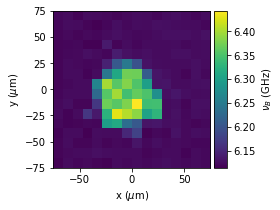

In [11]:
#Read data and create sub-data frame with X, Y and Shift; add columns in um (from mm)
data = pd.read_csv(fc.selected)
datasub = data[[" X (mm)", " Y (mm)", " Shift (GHz)"]]
datasub["X (um)"]=datasub.iloc[:,0]* 1000.0
datasub["Y (um)"]=datasub.iloc[:,1]* 1000.0
#Pivot sub-data frame so that it can be plotted as a map with correct x and y coordinates
piv=datasub.pivot(index = "Y (um)",columns="X (um)",values=" Shift (GHz)")
piv=clean_df(piv)
fig,ax = plt.subplots(1,1, figsize=(4,4))
im = ax.imshow(piv,cmap="viridis",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
ax.set_xlabel("x ($\mu$m)")
ax.set_ylabel("y ($\mu$m)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='8%', pad=0.05)
plt.colorbar(mappable=im,ax=ax,cax=cax,fraction=0.05,label=r"$\nu_B$ (GHz)")
fig.tight_layout()
ax.grid(False)
plt.show()

#TODO 
#read binary image and multiply map 

In [5]:
outliersw = widgets.Dropdown(
    options=[('Yes', True), ('No', False)],
    value=False,
    description='Outliers?:',
)
display(outliersw)

Dropdown(description='Outliers?:', index=1, options=(('Yes', True), ('No', False)), value=False)

In [6]:
def screen_outliers(v_min=5.9,v_max=6.5):
    fig,axs = plt.subplots(1,2, figsize=(10,5))
    cond = ((piv > v_min) & (piv < v_max))
    axs[0].hist(np.array(piv[cond]).flatten(),bins="auto")
    axs[0].axvline(v_min,c='r')
    axs[0].axvline(v_max,c='r')
    im1=axs[1].imshow(piv[cond],cmap="viridis",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
    titles = ["2D histogram","Image"]
    for i,ax in enumerate(axs):
        ax.set_title(titles[i])
        ax.grid(False)
        if i == 0:
            ax.set_ylabel("Counts")
            ax.set_xlabel(r"$\nu_B$ (GHz)")
            #skip color map for histogram
            continue
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='8%', pad=0.05)
        ax.set_xlabel("x $(\mu m)$")
        ax.set_ylabel("y $(\mu m)$")
        plt.colorbar(mappable=im1,ax=axs[1],cax=cax,fraction=0.05,label=r"$\nu_B$ (GHz)")
    fig.tight_layout()
if outliersw.value is True: 
    screen_outliers_interactive= widgets.interactive(screen_outliers,v_min=(0,6.5,0.1),v_max=(5,8,0.1))
    display(screen_outliers_interactive)
    v_min_cond = screen_outliers_interactive.kwargs["v_min"]
    v_max_cond = screen_outliers_interactive.kwargs["v_max"]
    piv = piv[((piv>v_min_cond) & (piv<v_max_cond))]
else:
    piv = piv 

### 2) Run cell below to display cleaned Brillouin map 

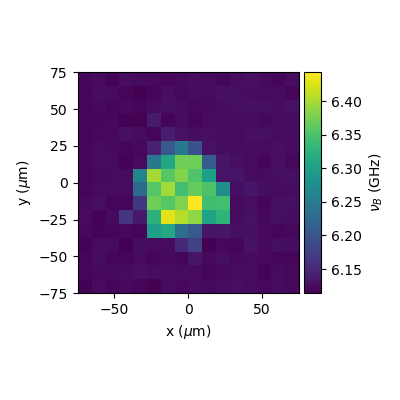

In [7]:
fig,ax = plt.subplots(1,1, figsize=(4,4))
im = ax.imshow(piv,cmap="viridis",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
ax.set_xlabel("x ($\mu$m)")
ax.set_ylabel("y ($\mu$m)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='8%', pad=0.05)
plt.colorbar(mappable=im,ax=ax,cax=cax,fraction=0.05,label=r"$\nu_B$ (GHz)")
fig.tight_layout()
ax.grid(False)
plt.show()

### 3) Run cell below to display line profiles along x and  y

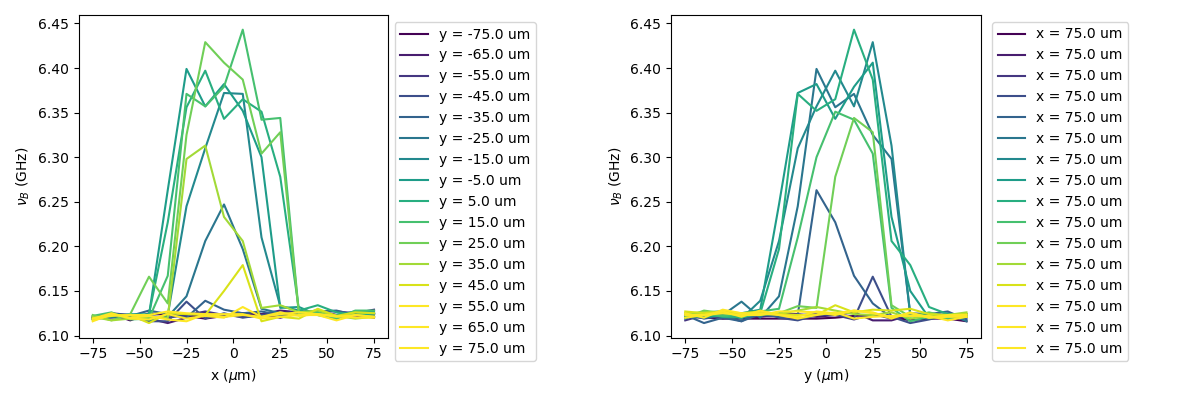

In [8]:
#Plot profiles along X and Y
fig, axs = plt.subplots(1,2,figsize=(12,4))
color = cm.viridis(np.linspace(0,20,len(datasub["Y (um)"])))
for i,y in enumerate(piv.index):
    axs[0].plot(piv.columns,piv.loc[y,:],color=color[i],label="y = " +str(y)+ " um")
axs[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axs[0].set_xlabel("x ($\mu$m)")

color = cm.viridis(np.linspace(0,20,len(datasub["X (um)"])))
for i,x in enumerate(piv.columns):
    axs[1].plot(piv.index,piv.loc[:,x],color=color[i],label="x = " +str(y)+ " um")
axs[1].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axs[1].set_xlabel("y ($\mu$m)")

for ax in axs: 
    ax.set_ylabel(r"$\nu_B$ (GHz)")
    ax.grid(False)
fig.tight_layout()
plt.show()

### 4) Run cell below in order in order to interactively threshold the Brillouin map <br> 
Briefly, a simple threshold based on the 2D histogram of the flattened map is used for discriminating between background and object of interest. Plots are automatically updated and the average for both background and object is shown as the threshold is changed. <bk>
You can copy and paste those values in Prism in order to run statistics.

In [9]:
%matplotlib inline
def threshold_image(threshold=6.20):
    back = piv[piv<threshold]
    sph = piv[piv>threshold]
    fig,axs= plt.subplots(1,4,figsize=(15,3))
    axs[0].hist(np.array(piv).flatten(),bins="auto",color='k')
    axs[0].axvline(threshold,color='red')
    im1=axs[1].imshow(piv,cmap="viridis",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
    im2=axs[2].imshow(back,cmap="viridis",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
    im3=axs[3].imshow(sph,cmap="viridis",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
    all = [im1,im2,im3]
    titles = ["2D histogram", "Full map", "Background", "Object"]
    for i,ax in enumerate(axs):
        ax.set_title(titles[i])
        ax.grid(False)
        if i == 0:
            ax.set_ylabel("Counts")
            ax.set_xlabel(r"$\nu_B$ (GHz)")
            #skip color map for histogram
            continue
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='8%', pad=0.05)
        ax.set_xlabel("x $(\mu m)$")
        ax.set_ylabel("y $(\mu m)$")
        plt.colorbar(mappable=all[i-1],ax=axs[i],cax=cax,fraction=0.05,label=r"$\nu_B$ (GHz)")
    fig.tight_layout()
plt.close()
threshold_image_interactive= widgets.interactive(threshold_image,threshold=(5,7,0.01))
display(threshold_image_interactive)                             

interactive(children=(FloatSlider(value=6.2, description='threshold', max=7.0, min=5.0, step=0.01), Output()),…

### 5) Run cell below in order to compute the mean of the background and object <bk>
You can then copy and paste those values in any software of preference (e.g., Prism) for statistical tests and furhter plotting!

In [10]:
threshold = threshold_image_interactive.kwargs["threshold"]
mean_back = np.nanmean(piv[piv<threshold_image_interactive.kwargs["threshold"]])
sd_back = np.nanstd(piv[piv<threshold_image_interactive.kwargs["threshold"]])
mean_object = np.nanmean(piv[piv>threshold_image_interactive.kwargs["threshold"]])
sd_object = np.nanstd(piv[piv>threshold_image_interactive.kwargs["threshold"]])
print("Threshold value: {threshold: .2f}".format(threshold=threshold))
print("Object's Average BrillouinShift p/m 1SD (GHz):{mean_object: .3f} p/m {sd_object:.3f}".format(mean_object=mean_object, sd_object=sd_object))
print("Background's Average BrillouinShift p/m 1SD (GHz):{mean_back: .3f} p/m {sd_back:.3f}".format(mean_back=mean_back, sd_back=sd_back))

Threshold value:  6.20
Object's Average BrillouinShift p/m 1SD (GHz): 6.328 p/m 0.064
Background's Average BrillouinShift p/m 1SD (GHz): 6.124 p/m 0.009


### 6) And... Run the two cells below if you want a .tsv file with individual values from object and background
The file can be opened in Excel, and used for further analysis!

In [ ]:
data = pd.read_csv(fc.selected)
shift = data[" Shift (GHz)"]
shift = clean_df(shift)
fw = shift[shift>threshold_image_interactive.kwargs["threshold"]]
bk = shift[shift<threshold_image_interactive.kwargs["threshold"]]
data = {"Background (GHz)": fw,
                    "Object (GHz)": bk}

df = pd.DataFrame(data=data)

samplenamew=widgets.Text(placeholder='Please enter the sample name',disabled=False)

namebox=widgets.HBox([widgets.Label(value="Sample Name:"), samplenamew])
display(namebox)

savedir=widgets.Text(
    placeholder='Please enter saving directory',
    disabled=False
)

savebox=widgets.HBox([widgets.Label(value="Saving directory:"), savedir])
display(savebox)

In [ ]:
fname=savedir.value+"/"+samplenamew.value+".tsv"
with open(fname, 'w') as f:
    f.write("Background (GHz) \t Object (GHz) \n")
    for x in zip_longest(*[bk, fw]):
        f.write("{0}\t{1}\n".format(*x))